## Case Study: Menu & Recipe Orders Insights

#### Based on the data provided, our aim is to analyse the trend and identify the important performance metric that contributes toward total order performance.

In [506]:
# importing the necessary libraries
import psycopg2 as pg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [329]:
# Connect to postgresql database
conn = pg2.connect(
    host="datatest.c1st3pkospxj.eu-west-1.rds.amazonaws.com",
    database="datatest_forecaster",
    user="candidate",
    password="Gou5toB0X")

In [513]:
# import data from postgresql
df = pd.read_sql('SELECT menu_id, AVG(actual_number) AS actual_orders, AVG(forecasted_number) AS forecasted_orders, ROUND((AVG(actual_number)- AVG(forecasted_number)) * 100.0 / AVG(actual_number), 2) AS Percentage FROM orders_actual_forecast GROUP BY menu_id ORDER BY actual_orders DESC', conn)
df.describe()

,menu_id,actual_orders,forecasted_orders,percentage
count,46.000000,46.000000,46.000000,46.000000
mean,23.500000,2256.946640,2300.191304,-2.150435
std,13.422618,774.291209,774.968123,0.768985
min,1.000000,891.500000,934.090909,-4.780000
25%,12.250000,1710.693182,1755.784091,-2.462500
50%,23.500000,2078.954545,2124.090909,-2.165000
75%,34.750000,2708.034091,2749.750000,-1.515000
max,46.000000,3915.500000,3961.909091,-1.100000


### Actual vs Estimated Order Number

This chart shows the comparison between the actual and estimated order, as well as the performance trend across the menu.
The chart on the lower part describes the difference between actual and estimated number of orders.
Based on the figure, we are able to see that there is no menu that managed to meet their expected number of orders.

<img src="Actual Order vs Forecast.png">

*Visualization created using Tableau*\
*Sources: https://public.tableau.com/app/profile/nurulsaidi/viz/PartAnalysisMenu/ActualOrdervsForecast#1*

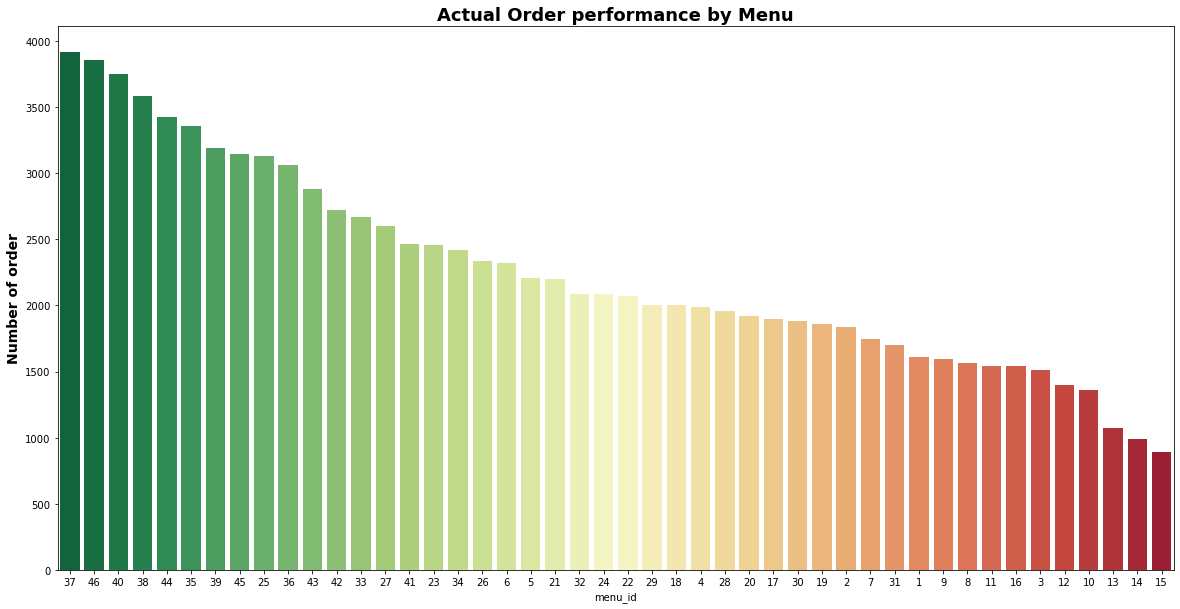

In [508]:
#actual order performances by menu
top_nr = df.sort_values(by='actual_orders', ascending = False)
fig,axs = plt.subplots(1, 1, figsize=(20,10))
sns.barplot(x='menu_id', y='actual_orders', data = df, order= top_nr['menu_id'], palette='RdYlGn_r')
plt.ylabel('Number of order',fontsize=14,fontweight="bold")
plt.title('Actual Order performance by Menu',fontsize=18,fontweight="bold")
# sns.barplot(x='menu_id', y='percentage', data = df, order= bottom_10['menu_id'], ax=axs[1], palette='GnBu')
plt.show()

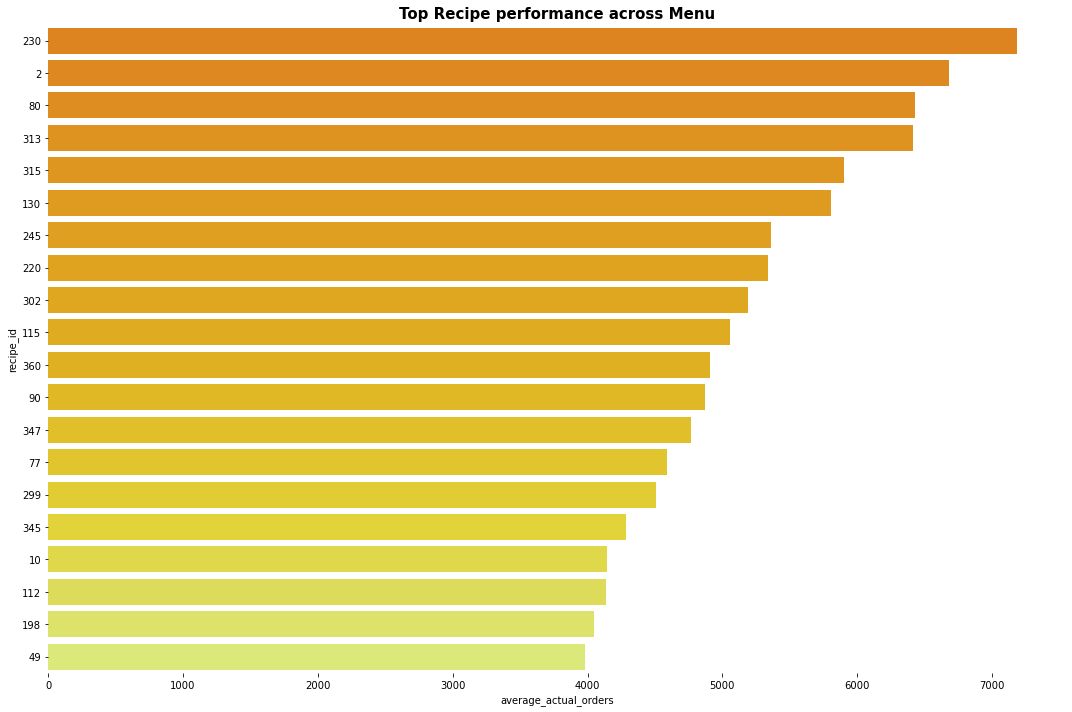

In [509]:
# Recipe performance across menu

df_avgrecipe = pd.read_sql("SELECT DISTINCT(recipe_id) , AVG(actual_number) OVER (PARTITION BY recipe_id) AS average_actual_orders FROM orders_actual_forecast GROUP BY recipe_id, actual_number ORDER BY average_actual_orders", conn)
# df_toprecipe_topmenu = df_toprecipe.groupby
df_avgrecipe.head(20)

# average number of recipe id performance across all menus
avg_recipe = df_avgrecipe.sort_values(by='average_actual_orders', ascending = False).head(20)
avg_recipe['recipe_id'] = avg_recipe['recipe_id'].astype('category')
fig,axs = plt.subplots(figsize=(15,10))
sns.barplot(x='average_actual_orders', y='recipe_id', data = avg_recipe,order= avg_recipe['recipe_id'], palette='Wistia_r')
sns.despine(left=True, bottom=True)
# plt.ylabel('Average Number of order',fontsize=14,fontweight="bold")
plt.title('Top Recipe performance across Menu',fontsize=15,fontweight="bold")
plt.tight_layout()

Text(0.5, 1.0, 'Total Number of Recipe by Menu')

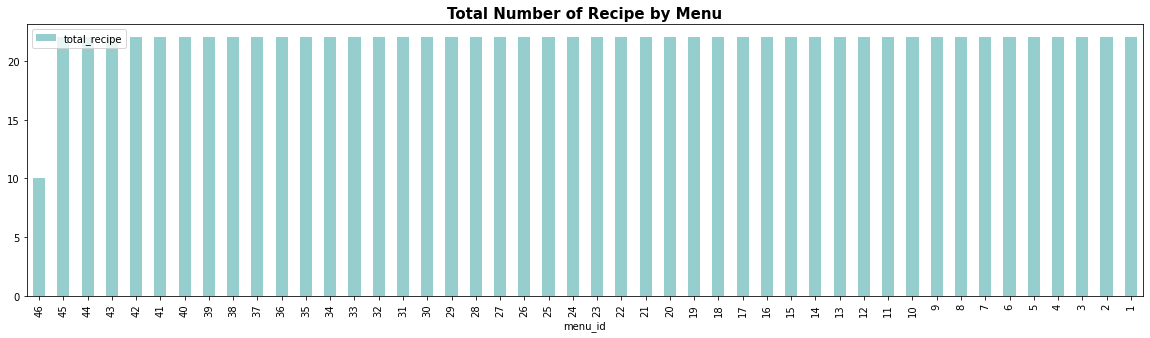

In [514]:
# Determine the number of recipe for every menu.

df_recipepermenu = pd.read_sql('SELECT distinct(menu_id), sum(count(recipe_id)) OVER (PARTITION BY menu_id ORDER BY menu_id) AS Total_recipe FROM orders_actual_forecast GROUP BY menu_id, recipe_id ORDER BY menu_id DESC', conn)
df_recipepermenu.plot.bar(x = 'menu_id', y ='total_recipe', color = '#96CDCD', figsize = (20,5) )
plt.title('Total Number of Recipe by Menu',fontsize=15,fontweight="bold")

All menu recorded the same number of recipes except menu 46. This may explains the reason menu 46 has the highest percentage difference between actual and forecasted number of orders. With limited number of recipes available on the menu 46, the demand might have shifted to other menu with more choices.

In [518]:
# import data of total orders by recipe and recipe title.

df_recipetitle = pd.read_sql("SELECT DISTINCT(recipe_id), title , AVG(value) OVER (PARTITION BY recipe_id) AS average_actual_orders  FROM tbl_orders_actual_wmenu ORDER BY average_actual_orders  DESC", conn)
df_recipetitle.head(10)

,recipe_id,title,average_actual_orders
0,230,Thai Chicken Noodles,7186.000000
1,2,Simple Chicken Red Curry,6677.933333
2,80,Fragrant Chicken Stir Fry,6431.750000
3,313,Thai Chicken Red Curry,6412.466667
4,315,Speedy Steak Green Curry,5900.800000
5,130,Spicy Beef Pad Thai,5801.800000
6,245,Thai Beef Green Curry,5357.900000
7,220,Simple Beef Noodles,5341.444444
8,302,Thai Steak Green Curry,5192.333333
9,115,Quick Chicken Rogan Josh,5054.400000


In [511]:
# import data of total orders by box type, collections, cuisines and protein. 

# box type df
df_boxtype = pd.read_sql("SELECT B.description, SUM(value) as Order_Number FROM tbl_orders_actual_wmenu A JOIN box_types B on A.box_type_id = B.id GROUP BY description", conn)
# collections df
df_collections = pd.read_sql("SELECT B.description, SUM(value) as Order_Number FROM tbl_orders_actual_wmenu A JOIN collections B on A.collection_id = B.id GROUP BY description", conn)
# cuisines df
df_cuisines = pd.read_sql("SELECT B.description, SUM(value) as Order_Number FROM tbl_orders_actual_wmenu A JOIN cuisines B on A.cuisine_id = B.id GROUP BY description ORDER BY Order_Number DESC", conn)
# proteins df
df_proteins = pd.read_sql("SELECT B.description, SUM(value) as Order_Number FROM tbl_orders_actual_wmenu A JOIN proteins B on A.protein_id = B.id GROUP BY description ORDER BY Order_Number DESC", conn)

<AxesSubplot:ylabel='order_number'>

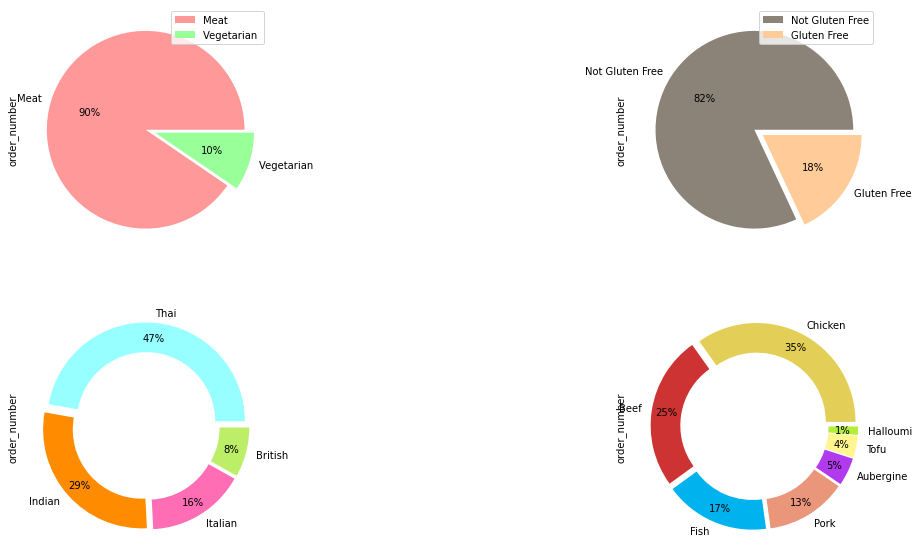

In [512]:
# create pie chart of total orders by box type, collections, cuisines and protein.
plt.figure(figsize=(20,10))
plt.tight_layout()
# plt.subplots(2, 1, figsize=(15,15))
ax1 = plt.subplot(221, aspect='equal')
ax2 = plt.subplot(222, aspect='equal')
ax3 = plt.subplot(223, aspect='equal')
ax4 = plt.subplot(224, aspect='equal')
df_boxtype.plot.pie(y = 'order_number', labels = df_boxtype['description'] ,ax = ax1, explode = (0, 0.1) ,autopct='%.0f%%' , colors = ['#ff9999','#99ff99'] )
df_collections.plot.pie(y = 'order_number', labels = df_collections['description'] ,ax = ax2, explode = (0, 0.1) ,autopct='%.0f%%' , colors = ['#8B8378','#ffcc99'] )
df_cuisines.plot.pie(y = 'order_number', labels = df_cuisines['description'] ,ax = ax3 ,wedgeprops=dict(width=.3),pctdistance=0.85,explode = (0.05,0.05,0.05,0.05),colors = ['#97FFFF','#FF8C00','#FF6EB4','#BCEE68'], autopct='%.0f%%' , legend=False)
df_proteins.plot.pie(y = 'order_number', labels = df_proteins['description'] ,ax = ax4 ,wedgeprops=dict(width=.3),pctdistance=0.85,explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05),colors = ['#E3CF57','#CD3333','#00B2EE','#E9967A','#B23AEE','#FFF68F','#B3EE3A'], autopct='%.0f%%', legend=False )

Above pie charts desribe the demand based on ingredients and type of cuisines. Menu with high number of orders most probably consists the most preferred ingredients and cuisines by customer.

### Recommendation

Optimal forecasting model requires high accuracy of predictive trend based on customer behaviour and demand elesticity.
From this analysis, we can focus on creating a better combination of recipes in the menu to increase sales.
It is also equaly important to determine the incremental impacts of new menu initiatives and to plan resources in response to expected demand. 

There are other important factors that have not be considered in this analysis including the seasonality trend, pricing and promotion activities, sales distribution channel, resources constraint and others.

### Conclusion

As our conclusion, based on this analysis we can identify what we should add or remove from the menu in terms of ingredients choice and cuisines types.

In [495]:
# conn.close ()